In [87]:
from uq360.algorithms.layer_scoring import (aklpe, knn, mahalanobis)
from uq360.utils.transformers.nearest_neighbors.exact import ExactNearestNeighbors
from uq360.utils.transformers.nearest_neighbors.faiss import FAISSNearestNeighbors


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from scipy.stats import bootstrap

import numpy as np

import torch
from torch.nn import Sequential, Linear, ReLU, Softmax, Conv2d, MaxPool2d, Flatten
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from tempfile import TemporaryDirectory
from collections import namedtuple
from datetime import datetime


# DELETE ME 
import seaborn as sns

# Introduction

The models defined in `uq360.algorithms.layer_scoring` perform anomaly detection, which can be used to estimate epistemic uncertainty, based on proxies for data density estimation in the latent space of neural networks.

We provide three models:

1. `knn.KNNScorer` which builds a metric by combining the distances from a query data point to the k-nearest neighbors in the latent space.
2. `aklpe.AKLPEScorer` uses the same KNN distances to build a p-value by comparing them to the distances found in the training distribution.
3. `mahalanobis.MahalanobisScorer` uses the non-parametric Mahalanobis distance, which uses the covariance matrix of the training data as a bilinear operator to build a distance to the centroid of the training dataset.

# Data

We study a simple setup: the MNIST dataset.

In [3]:
# Protecting the raw data

BunchTuple = namedtuple('BunchTuple', ['data','target', 'frame', 'categories', 'feature_names', 
                         'target_names', 'DESCR', 'details', 'url'])

In [4]:
try:
    dataset
    print("Don't re-download the dataset!")
except NameError:
    with TemporaryDirectory() as tmp_dir:
        dataset = fetch_openml(data_id=41063)#, data_home=tmp_dir)
        dataset = BunchTuple(**dataset)

(62000, 1, 28, 28)


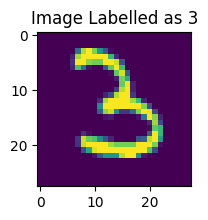

In [108]:
img = dataset.data.values.reshape(-1, 1, 28, 28).astype(np.float32)
y = dataset.target.values.astype(np.int)
img_train, img_test, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=1234)
print(img.shape)
ax = plt.gca()
ax.imshow(img[148].squeeze())
ax.set(title=f"Image Labelled as {y[148]}")
ax.get_figure().set_size_inches(2,2)
plt.show()

# Training a model to analyze

In [6]:
def get_cnn(k=16):
    return Sequential(
        Conv2d(1,k,kernel_size=3, padding="same"),
        ReLU(),
        Conv2d(k,k,kernel_size=3, padding="same"),
        MaxPool2d(kernel_size=2),
        Conv2d(k,2*k,kernel_size=3, padding="same"),
        Conv2d(2*k, 2*k,kernel_size=3, padding="same"),
        ReLU(),
        MaxPool2d(kernel_size=2),
        Conv2d(2*k, 3*k,kernel_size=3, padding="same"),
        MaxPool2d(kernel_size=7),
        Flatten(),
        Linear(3*k, k),
        ReLU(),
        Linear(k,10),
        Softmax(dim=1)
    )

In [7]:
class BasicDataset(Dataset):
    def __init__(self, **kwargs):
        self.data = kwargs
    def __getitem__(self, i):
        return {k: self.data[k][i] for k in self.data}
    def __len__(self):
        lens = {len(v) for v in self.data.values()}
        assert len(lens) == 1
        return lens.pop()

In [8]:
ds_train=BasicDataset(img=img_train, y=y_train)
ds_test=BasicDataset(img=img_test, y=y_test)
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=32)

In [9]:
def train_cnn(return_model=True, max_epochs=100):
    cnn = get_cnn()
    optim = Adam(cnn.parameters())
    loss_fcn = torch.nn.NLLLoss()
    
    train_accs = []
    train_losses = []
    train_times = []
        
    test_accs = []
    test_losses = []
    test_times = []
    
    
    
    # First Test Epoch
    test_epoch_iter = tqdm(dl_test, f"First Test Loop", leave=False)
    epoch_test_losses = []
    epoch_test_accs = []
    with torch.no_grad():
        for b_idx, test_batch in enumerate(test_epoch_iter):
            X = test_batch['img']
            y = test_batch['y']

            yhat = cnn(X)
            # NLLLoss takes log-probs as inputs
            loss = loss_fcn(yhat.log(), y)
            acc = (y == torch.argmax(yhat, dim=1))

            current_loss = loss.detach().numpy()
            current_acc = np.mean(acc.detach().numpy())

            epoch_test_losses.append(current_loss)
            epoch_test_accs.append(current_acc)
            if b_idx%10 == 0:
                test_epoch_iter.set_description(f"First Test Loop, Loss: {current_loss:.1e}")


    test_accs.append(np.mean(epoch_test_accs))
    test_losses.append(np.mean(epoch_test_losses))
    test_times.append(datetime.now())  
        
    top_iter = tqdm(range(max_epochs), f"Test Loss: {np.mean(epoch_test_losses):.1e}")
    for epoch in top_iter:
        epoch_iter = tqdm(dl_train, f"Loss: ?", leave=False)
        # Training Epoch
        for b_idx, train_batch in enumerate(epoch_iter):
            optim.zero_grad()
            X = train_batch['img']
            noise = torch.empty_like(X).normal_(0,0.1)
            y = train_batch['y']
            
            yhat = cnn(X+noise)
            # NLLLoss takes log-probs as inputs
            loss = loss_fcn(yhat.log(), y)
            loss.backward()
            optim.step()
            
            with torch.no_grad():
                acc = (y == torch.argmax(yhat, dim=1))
            
            current_loss = loss.detach().numpy()
            curent_acc = np.mean(acc.detach().numpy())
            
            train_accs.append(curent_acc)
            train_losses.append(current_loss)
            train_times.append(datetime.now())
            if b_idx%10 == 0:
                epoch_iter.set_description(f"Loss: {current_loss:.1e}")
                
                
        # Test Epoch
        test_epoch_iter = tqdm(dl_test, f"Test Loss: ?", leave=False)
        epoch_test_losses = []
        epoch_test_accs = []
        with torch.no_grad():
            for b_idx, test_batch in enumerate(test_epoch_iter):
                X = test_batch['img']
                y = test_batch['y']

                yhat = cnn(X)
                # NLLLoss takes log-probs as inputs
                loss = loss_fcn(yhat.log(), y)
                acc = (y == torch.argmax(yhat, dim=1))

                current_loss = loss.detach().numpy()
                current_acc = np.mean(acc.detach().numpy())

                epoch_test_losses.append(current_loss)
                epoch_test_accs.append(current_acc)
                if b_idx%10 == 0:
                    test_epoch_iter.set_description(f"Test Loss: {current_loss:.1e}")
            
            
        test_accs.append(np.mean(epoch_test_accs))
        test_losses.append(np.mean(epoch_test_losses))
        test_times.append(datetime.now())    
        top_iter.set_description(f"Test Loss: {np.mean(epoch_test_losses):.1e}")        

            
    result = dict(train_losses=train_losses, train_accs=train_accs, train_times=train_times, 
                  test_losses=test_losses, test_accs=test_accs, test_times=test_times)
    if return_model:
        result.update(model=cnn)
    return result
    
            

In [10]:
result = train_cnn(max_epochs=2)

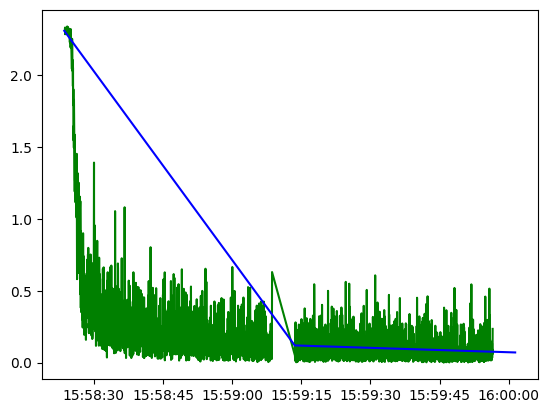

In [11]:
plt.plot(result['train_times'], result['train_losses'], c='green')
plt.plot(result['test_times'], result['test_losses'], c='blue')
plt.show()

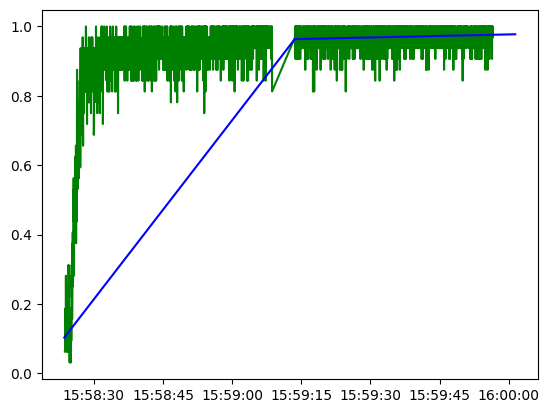

In [12]:
plt.plot(result['train_times'], result['train_accs'], c='green')
plt.plot(result['test_times'], result['test_accs'], c='blue')
plt.show()

# Generating perturbed data

We will perturb our data in a very simple and artificial manner: we will offset its mean in a progressive fashion.
The contrast between the numbers and the background will progressively deteriorate, but still be very readable for a human, while degrading model performance fast.

In [13]:
model = result['model']
model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (9): MaxPool2d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=48, out_features=16, bias=True)
  (12): ReLU()
  (13): Linear(in_features=16, out_features=10, bias=True)
  (14): Softmax(dim=1)
)

In [14]:
def noise_offset_inputs(X, noise_offset=0, noise_lvl=0.1):
    X = torch.tensor(X).to(torch.float32)
    noise = torch.empty_like(X).normal_(noise_offset, noise_lvl)
    # Maintaining [0,1] normalization
    return X*(1-noise)+noise

def get_preds(model, X):
    X = torch.tensor(X).to(torch.float32)
    with torch.no_grad():
        return model(X)

def accuracy(yhat,y):
    yhat = torch.tensor(yhat).to(torch.float32)
    y = torch.tensor(y).to(torch.long)
    hits = torch.argmax(yhat,dim=1) == y
    acc = torch.mean(hits.to(float)).numpy().item()
    return acc

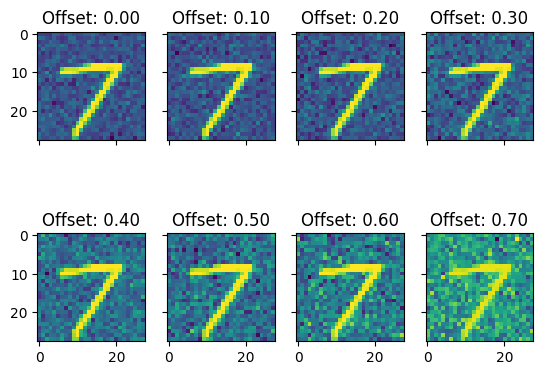

In [15]:
accs = []
fig,axs = plt.subplots(2,4, sharex=True, sharey=True)
axs = iter(axs.flatten())

for noise_offset in tqdm(np.linspace(0,0.7,8)):
    img_noised = noise_offset_inputs(img_test, noise_offset=noise_offset)
    ax = next(axs)
    ax.imshow(img_noised[18].squeeze())
    ax.set(title=f"Offset: {noise_offset:.2f}")
    
    yhat = get_preds(model, img_noised)
    accs.append(accuracy(yhat, y_test))

plt.show()

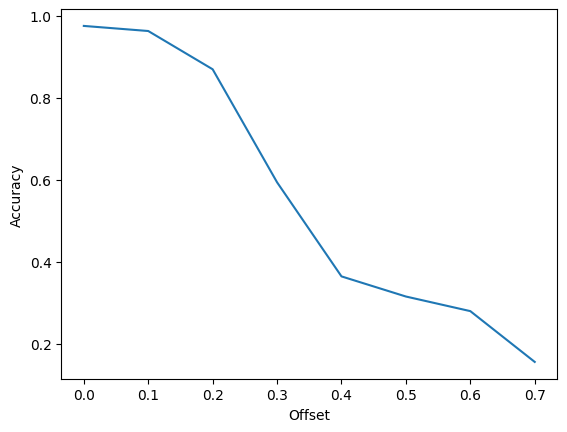

In [16]:
ax = plt.gca()
ax.plot(np.linspace(0,0.7,8),accs)
ax.set(xlabel='Offset',ylabel='Accuracy')
plt.show()

# Measuring Epistemic uncertainty with KNN Distances

In [17]:
# Late layer from which to extract latents
layer = model[11]
print(layer)
knn_uq = knn.KNNScorer(n_neighbors=10, 
                       nearest_neighbors=ExactNearestNeighbors, 
                       model=model, 
                       layer=layer, 
                       method='avg')

Linear(in_features=48, out_features=16, bias=True)


In [18]:
knn_uq.fit(X=img_train)

In [19]:
dists = []
for noise_lvl in tqdm(np.linspace(0,0.7,8)):
    img_noised = noise_offset_inputs(img_test, noise_lvl)
    distances = knn_uq.predict(img_noised)
    dists.append(distances)

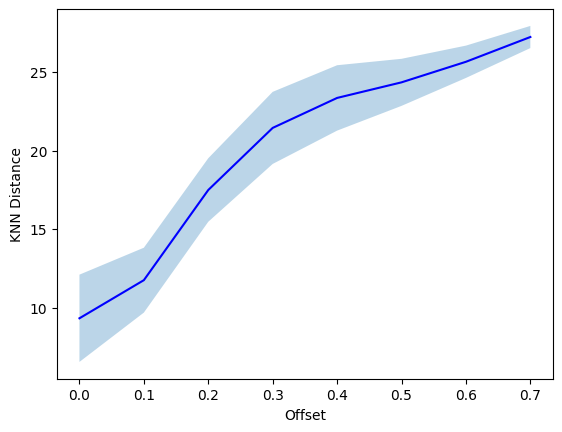

In [20]:
ax = plt.gca()
ax.fill_between(np.linspace(0,0.7,8), 
                 [np.mean(d)-np.std(d) for d in dists], 
                 [np.mean(d)+np.std(d) for d in dists],
                 alpha=0.3
                )
ax.plot(np.linspace(0,0.7,8), [np.mean(d) for d in dists], c='blue')
ax.set(xlabel='Offset', ylabel='KNN Distance')
plt.show()


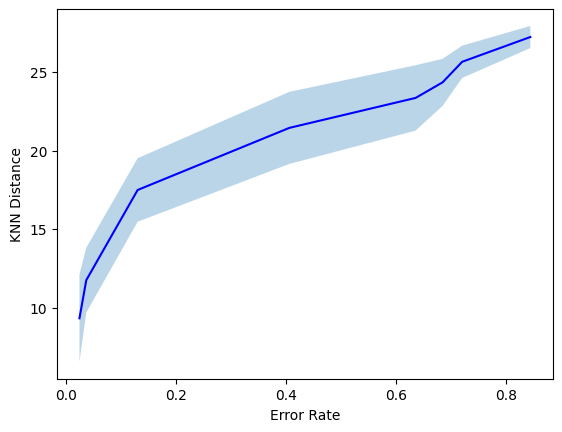

In [21]:
ax = plt.gca()
ax.fill_between(1-np.array(accs),                  
        [np.mean(d)-np.std(d) for d in dists], 
        [np.mean(d)+np.std(d) for d in dists],
        alpha=0.3)
ax.plot(1-np.array(accs), [np.mean(d) for d in dists], c='blue')
ax.set(ylabel='KNN Distance', xlabel='Error Rate')
plt.show()

# Measuring Epistemic uncertainty with AKLPE

In [49]:
# Here we will compute the latents outside of the uncertainty estimator
aklpe_uq = aklpe.AKLPE(n_neighbors=10, 
                       nearest_neighbors=FAISSNearestNeighbors)

In [51]:
headless_model = model[:12]
print(headless_model[-1])

with torch.no_grad():
        z_train = headless_model(noise_offset_inputs(img_train,0,0))


Linear(in_features=48, out_features=16, bias=True)


In [52]:
aklpe_uq.fit(X=z_train)

In [53]:
z_noises = []
for noise_lvl in tqdm(np.linspace(0,0.7,8)):
    img_noised = noise_offset_inputs(img_test, noise_lvl)
    with torch.no_grad():
        z_noises.append(headless_model(img_noised))

In [54]:
dist = []
for z_noise in tqdm(z_noises):
    distances = aklpe_uq.predict(z_noise)
    dist.append(distances)

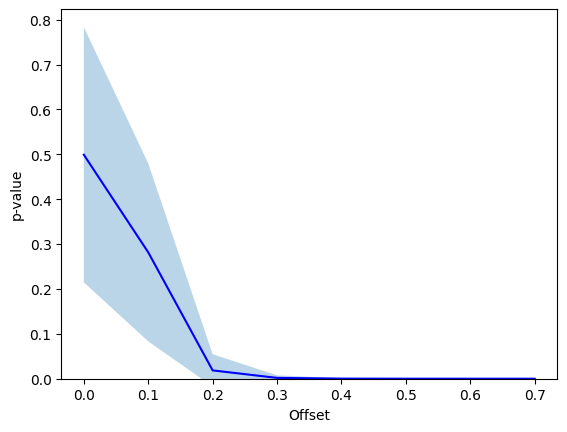

In [105]:
ax = plt.gca()
ax.fill_between(np.linspace(0,0.7,8), 
                 [np.mean(d[1])-np.std(d[1]) for d in dist], 
                 [np.mean(d[1])+np.std(d[1]) for d in dist],
                 alpha=0.3
                )
ax.plot(np.linspace(0,0.7,8), [np.mean(d[1]) for d in dist], c='blue')
ax.set(xlabel='Offset', ylabel='p-value')
ax.set(ylim=[0,None])
plt.show()

# Measuring Epistemic uncertainty with Mahalanobis

In [106]:
# Here we will compute the latents outside of the uncertainty estimator
maha_uq = mahalanobis.MahalanobisScorer()

In [109]:
maha_uq.fit(X=z_train, y=y_train)

In [110]:
dist = []
for z_noise in tqdm(z_noises):
    distances = maha_uq.predict(z_noise)
    dist.append(distances)

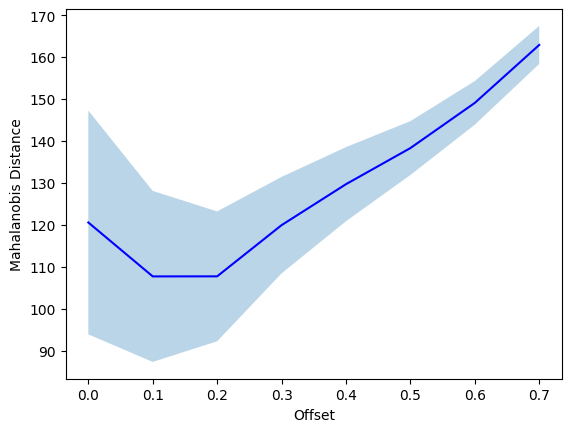

In [113]:
ax = plt.gca()
ax.fill_between(np.linspace(0,0.7,8), 
                 [np.mean(d)-np.std(d) for d in dist], 
                 [np.mean(d)+np.std(d) for d in dist],
                 alpha=0.3
                )
ax.plot(np.linspace(0,0.7,8), [np.mean(d) for d in dist], c='blue')
ax.set(xlabel='Offset', ylabel='Mahalanobis Distance')
plt.show()
